# MT Data

*(datetime, math and sqlite3 will be imported by json_header)*

ATSS is ats simplified or ats stream

.atss consists of double numbers *only*

.json contains *all* data needed for a *complete* processing


In [182]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import rfft, irfft
from scipy import signal
import sys, os
import json

# Ensure the path to the module is in the system path
sys.path.append(os.path.realpath('../../include'))
try:
  import json_header as jh
except ModuleNotFoundError:
  print("Module 'json_header' not found. Please ensure the module is available in the Python path.")


In [183]:
import sys
import os
# open a data file with doubles (.atss) and the json header (.json)
filename = '/home/bfr/devel/ats_data/noise_gernerator/001_ADU-08e_C000_TEx_1024Hz'
if not os.path.exists(filename + '.atss'):
    sys.exit("File atss (data) does not exist. Exiting the Jupyter Notebook.")
if not os.path.exists(filename + '.json'):
    sys.exit("File json header does not exist. Exiting the Jupyter Notebook.")


In [184]:
# read the header AND make a channel
# together with the filename
# calibration is included by default
channel = jh.read_atssheader(filename)
# print(json.dumps(channel, indent=2, sort_keys=False, ensure_ascii=False))


In [185]:
# continue if so
file = open(filename + ".atss", 'rb')
print("opening: ", filename + ".atss")
wl = 1024                                   # set a window length for plotting
# read wl
hx = np.fromfile(file, dtype = np.float64, count = wl)
hx = signal.detrend(hx)                     # for later FFT we need to detrend
#print(hx)

opening:  /home/bfr/devel/ats_data/noise_gernerator/001_ADU-08e_C000_TEx_1024Hz.atss


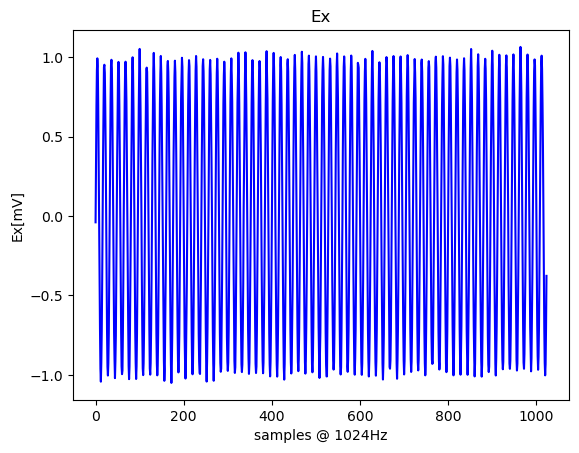

In [186]:
# plot the raw data
t = range(wl) # x axis
plt.title( channel['channel_type'])       # title
plt.xlabel("samples @ " + jh.sample_rate_to_string(channel['sample_rate']))
plt.ylabel(channel['channel_type'] + "[mV]")
plt.plot(t, hx, c='b', label='data')
plt.draw()


The calibration data is *always* included in the **JSON** file
When the header comes from an ADU system we stay with the *normalized by f* form;
this allows you to compare with the deleiverd txt files

$F_{on}(f) = \frac{ mV_{output} }{nT \enspace Hz} = 800 \frac{mV}{nT} \cdot \frac{P_1}{1+P_1} \cdot \frac{1}{1+P_2} \cdot \frac{1}{1+P_4} $


In [187]:

f_test = channel['sensor_calibration']['f']
if len(f_test) > 0:
  plt.title("calibration")  # title
  plt.xlabel("f [Hz]")
  plt.ylabel("mV/nT")       # that is the new unit, not normalized
  plt.loglog(channel['sensor_calibration']['f'],channel['sensor_calibration']['a'], label='chopper on', marker='.') # these are the values from the json header
  plt.show()

In [188]:
# To see the calibration "old style", simply divide by 1000. and by f in Hz. The calibration is in V/(Hz * nT).
if len(f_test) > 0:
    a_old = channel['sensor_calibration']['a']
    for i in range(len(channel['sensor_calibration']['a'])):
        a_old[i] = a_old[i] / 1000. / channel['sensor_calibration']['f'][i]

    plt.title("calibration old style")  # title
    plt.xlabel("f [Hz]")
    plt.ylabel("V/(Hz nT)")       # that is the old unit, normalized
    plt.loglog(channel['sensor_calibration']['f'],a_old, label='chopper on', marker='.')
    plt.show()

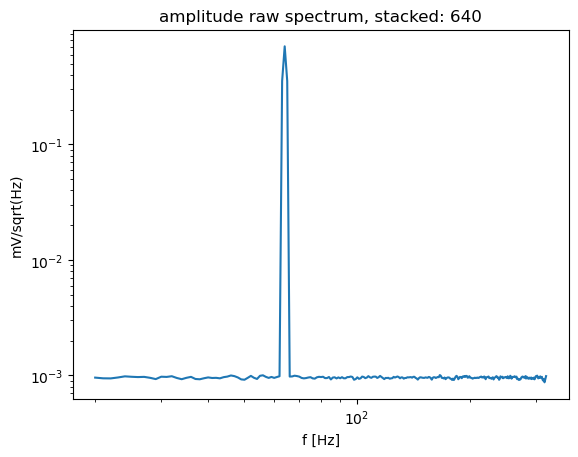

In [189]:
# go back to the beginning of the file
file.seek(0)
window = np.hanning(1024)                       # window for FFT
wincal = np.sqrt(1.0 / (1024.0 * 512.0))        # calibration for FFT
# wincal = 1.0
i_stacks = 0                                    # number of FFTs
# loop over the file until the end; read hx again and again
while True:
    try:
        hx = np.fromfile(file, dtype = np.float64, count = wl)
        if len(hx) == 0:
            break
        hxspc = hx * window        
        spec = rfft(hxspc, norm="backward")   # that is numpy default which includes some normalisation
        spec *= wincal * 2.                   # calibration for FFT
        ampl_spec = abs(spec)
        if i_stacks == 0:
            ampl_stack = ampl_spec
        else:
            ampl_stack += ampl_spec
        i_stacks += 1
    except EOFError:
        break
file.close()
ampl_stack /= i_stacks

ampl_stack = ampl_stack[20:320]         # take not the complete data - gives better scale
ampl_freq = np.linspace(20, 320, 300, endpoint=True)
ampl_freq = ampl_freq * channel['sample_rate'] / wl

plt.title("amplitude raw spectrum, stacked: " + str(i_stacks))  # title
plt.xlabel("f [Hz]")
plt.ylabel("mV/sqrt(Hz)")
plt.loglog(ampl_freq, ampl_stack)
plt.show()

In [190]:
# get the maximum value of the amplitude spectrum
max_value = np.max(ampl_stack)
print("Maximum value of the amplitude spectrum: ", max_value)

Maximum value of the amplitude spectrum:  0.7064139387699243
